In [49]:
!pip install sqlalchemy
!pip install pyodbc

In [50]:
from sqlalchemy import create_engine, Table, inspect
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from sklearn.utils import resample
from scipy.stats import sem, t

In [51]:
def new_engine(dialect, server, database, user=None, password=None, integrated_security=True):
    if integrated_security:
        # For Windows authentication
        eng = f"{dialect}://{server}/{database}?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server"
    else:
        # For SQL Server authentication
        eng = f"{dialect}://{user}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server"
    print(eng)
    return create_engine(eng)

In [52]:
# For Windows authentication
# Replace the server argument with the Server Name found when logging into SQL Server Management Studio 
# OR
# For SQL Server authentication
# Replace the server, user and password argument with the Server Name, username and password
engine = new_engine('mssql', 'MUSTAF', 'AdventureWorks2022', integrated_security=True)

mssql://MUSTAF/AdventureWorks2022?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server


In [53]:
print(type(engine))


<class 'sqlalchemy.engine.base.Engine'>


In [54]:
connection = engine.connect()
print(type(connection))

<class 'sqlalchemy.engine.base.Connection'>


In [55]:
inspector = inspect(engine)
schemas = inspector.get_schema_names()
print(schemas)

['db_accessadmin', 'db_backupoperator', 'db_datareader', 'db_datawriter', 'db_ddladmin', 'db_denydatareader', 'db_denydatawriter', 'db_owner', 'db_securityadmin', 'dbo', 'guest', 'HumanResources', 'INFORMATION_SCHEMA', 'Person', 'Production', 'Purchasing', 'Sales', 'sys', 'TEST']


In [56]:
for schema in schemas:
    print(schema)

db_accessadmin
db_backupoperator
db_datareader
db_datawriter
db_ddladmin
db_denydatareader
db_denydatawriter
db_owner
db_securityadmin
dbo
guest
HumanResources
INFORMATION_SCHEMA
Person
Production
Purchasing
Sales
sys
TEST


In [57]:
print(inspector.get_table_names(schema='Sales'))


['CountryRegionCurrency', 'CreditCard', 'Currency', 'CurrencyRate', 'Customer', 'PersonCreditCard', 'SalesOrderDetail', 'SalesOrderHeader', 'SalesOrderHeaderSalesReason', 'SalesPerson', 'SalesPersonQuotaHistory', 'SalesReason', 'SalesTaxRate', 'SalesTerritory', 'SalesTerritoryHistory', 'ShoppingCartItem', 'SpecialOffer', 'SpecialOfferProduct', 'Store']


In [58]:

sql_query = '''

    SELECT 
        e.BusinessEntityID,
        pp.FirstName,
        pp.LastName,
        ST.Name AS TerritoryName,
        YEAR(SOH.OrderDate) AS SalesYear,
        SUM(SOH.TotalDue) AS TotalSales
    FROM 
        HumanResources.Employee e
    JOIN 
        Sales.SalesPerson SP ON e.BusinessEntityID = SP.BusinessEntityID
    JOIN 
        Sales.SalesOrderHeader SOH ON SP.BusinessEntityID = SOH.SalesPersonID
    JOIN 
        Sales.SalesTerritory ST ON SP.TerritoryID = ST.TerritoryID
    JOIN 
        Person.Person pp ON e.BusinessEntityID = pp.BusinessEntityID
    WHERE 
        ST.CountryRegionCode = 'US'
        AND YEAR(SOH.OrderDate) IN (2012, 2013)
    GROUP BY 
        e.BusinessEntityID,
        pp.FirstName,
        pp.LastName,
        ST.Name,
        YEAR(SOH.OrderDate)
    ORDER BY 
        YEAR(SOH.OrderDate),  
        ST.Name;
'''

sales_usa_df = pd.read_sql(sql_query, con=connection)  

# Filtrera data för år 2012 och 2013
sales_2012_2013 = sales_usa_df[sales_usa_df['SalesYear'].isin([2012, 2013])]

# medelvärdet för år 2012 och 2013 separat
mean_sales_2012 = sales_2012_2013[sales_2012_2013['SalesYear'] == 2012]['TotalSales'].mean()
mean_sales_2013 = sales_2012_2013[sales_2012_2013['SalesYear'] == 2013]['TotalSales'].mean()
#standeravvikelse för år 2012 och 2013 separat
std_err_2012 = sales_2012_2013[sales_2012_2013['SalesYear'] == 2012]['TotalSales'].sem()
std_err_2013 = sales_2012_2013[sales_2012_2013['SalesYear'] == 2013]['TotalSales'].sem()
#observationer för år 2012 och 2013
n_2012 = sales_2012_2013[sales_2012_2013['SalesYear'] == 2012]['TotalSales'].count()
n_2013 = sales_2012_2013[sales_2012_2013['SalesYear'] == 2013]['TotalSales'].count()
# Beräkna 95% konfidensintervall för år 2012
confidence_interval_2012 = (mean_sales_2012 - 1.96 * (std_err_2012 / (n_2012) ** 0.5),
                           mean_sales_2012 + 1.96 * (std_err_2012 / (n_2012) ** 0.5))

# Beräkna 95% konfidensintervall för år 2013
confidence_interval_2013 = (mean_sales_2013 - 1.96 * (std_err_2013 / (n_2013) ** 0.5),
                           mean_sales_2013 + 1.96 * (std_err_2013 / (n_2013) ** 0.5))

print(f"Medelvärde för försäljningen år 2012: {mean_sales_2012:.2f}")
print(f"Medelvärde för försäljningen år 2013: {mean_sales_2013:.2f}")
print()
print(f"Standaravvikelse för försäljningen år 2012: {std_err_2012:.2f}")
print(f"Standaravvikelse för försäljningen år 2013: {std_err_2013:.2f}")
print()
print(f"Antal observationer för år 2012: {n_2012}")
print(f"Antal observationer för år 2013: {n_2013}")
print()

print(f"95% konfidensintervall för försäljningen år 2012: {confidence_interval_2012}")
print(f"95% konfidensintervall för försäljningen år 2013: {confidence_interval_2013}")



Medelvärde för försäljningen år 2012: 2741212.71
Medelvärde för försäljningen år 2013: 2770703.63

Standaravvikelse för försäljningen år 2012: 548761.32
Standaravvikelse för försäljningen år 2013: 496933.44

Antal observationer för år 2012: 8
Antal observationer för år 2013: 8

95% konfidensintervall för försäljningen år 2012: (2360940.509792149, 3121484.9039078513)
95% konfidensintervall för försäljningen år 2013: (2426346.3242209908, 3115060.9339290094)


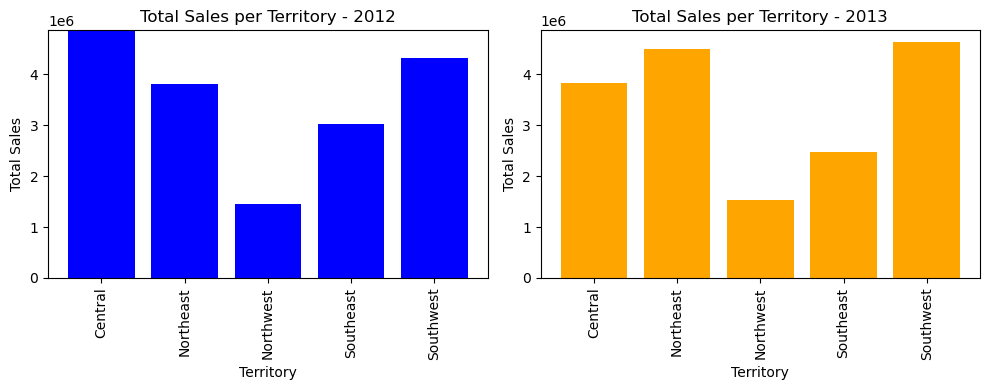

In [59]:
#Intäkter för år 2012 och 2013 för den olika försäljningsavdelningen i USA ser ut så här 


sql_query = """
SELECT 
    e.BusinessEntityID,
    pp.FirstName,
    pp.LastName,
    ST.Name AS TerritoryName,
    YEAR(SOH.OrderDate) AS SalesYear,
    SUM(SOH.TotalDue) AS TotalSales
FROM 
    HumanResources.Employee e
JOIN 
    Sales.SalesPerson SP ON e.BusinessEntityID = SP.BusinessEntityID
JOIN 
    Sales.SalesOrderHeader SOH ON SP.BusinessEntityID = SOH.SalesPersonID
JOIN 
    Sales.SalesTerritory ST ON SP.TerritoryID = ST.TerritoryID
JOIN 
    Person.Person pp ON e.BusinessEntityID = pp.BusinessEntityID
WHERE 
    ST.CountryRegionCode = 'US'
    AND YEAR(SOH.OrderDate) IN (2012, 2013)
GROUP BY 
    e.BusinessEntityID,
    pp.FirstName,
    pp.LastName,
    ST.Name,
    YEAR(SOH.OrderDate)
ORDER BY 
    YEAR(SOH.OrderDate),  -- Ordnar åren i stigande ordning
    ST.Name;
"""

df = pd.read_sql_query(sql_query, con=connection)


df_2012 = df[df['SalesYear'] == 2012]
df_2013 = df[df['SalesYear'] == 2013]

plt.figure(figsize=(10, 4))
# Första subploten för 2013
plt.subplot(1, 2, 1)  
plt.bar(df_2012['TerritoryName'], df_2012['TotalSales'], color='blue')
plt.xlabel('Territory')
plt.ylabel('Total Sales')
plt.title('Total Sales per Territory - 2012')
plt.xticks(rotation=90) 
plt.ylim(0, max(max(df_2012['TotalSales']), max(df_2013['TotalSales'])))  # Sätter samma y-axel skala för båda graferna


# Andra subploten för 2014
plt.subplot(1, 2, 2)  
plt.bar(df_2013['TerritoryName'], df_2013['TotalSales'], color='orange')
plt.xlabel('Territory')
plt.ylabel('Total Sales')
plt.title('Total Sales per Territory - 2013')
plt.xticks(rotation=90) 
plt.ylim(0, max(max(df_2012['TotalSales']), max(df_2013['TotalSales'])))  # Sätter samma y-axel skala för båda graferna


plt.tight_layout()
plt.show()


In [60]:
sql_an ='''SELECT 
    e.BusinessEntityID AS SalesPersonID,
    pp.FirstName,
    pp.LastName,
    e.JobTitle,
    ST.Name AS TerritoryName
FROM 
    HumanResources.Employee e
JOIN 
    HumanResources.EmployeeDepartmentHistory edh ON e.BusinessEntityID = edh.BusinessEntityID
JOIN 
    HumanResources.Department d ON edh.DepartmentID = d.DepartmentID
JOIN 
    Sales.SalesPerson SP ON e.BusinessEntityID = SP.BusinessEntityID
JOIN 
    Sales.SalesTerritory ST ON SP.TerritoryID = ST.TerritoryID
JOIN 
    Person.Person pp ON e.BusinessEntityID = pp.BusinessEntityID
WHERE 
    ST.CountryRegionCode = 'US'
    AND e.JobTitle = 'Sales Representative'
    '''
join_df = pd.read_sql(sql=sql_an, con=connection)
join_df.head(10)

,SalesPersonID,FirstName,LastName,JobTitle,TerritoryName
0,275,Michael,Blythe,Sales Representative,Northeast
1,276,Linda,Mitchell,Sales Representative,Southwest
2,277,Jillian,Carson,Sales Representative,Central
3,279,Tsvi,Reiter,Sales Representative,Southeast
4,280,Pamela,Ansman-Wolfe,Sales Representative,Northwest
5,281,Shu,Ito,Sales Representative,Southwest
6,283,David,Campbell,Sales Representative,Northwest
7,284,Tete,Mensa-Annan,Sales Representative,Northwest


In [61]:
# 01
# text för första frågan
a_sql ="""

SELECT 
    CASE WHEN CountryRegionCode = 'US' THEN 'USA' ELSE Name END AS TerritoryName,
    CountryRegionCode
FROM (
    SELECT 
        ROW_NUMBER() OVER (PARTITION BY CountryRegionCode ORDER BY Name) AS TerritoryOrder,
        Name,
        CountryRegionCode
    FROM Sales.SalesTerritory
) AS Subquery
ORDER BY TerritoryOrder, CountryRegionCode;

"""

join_df = pd.read_sql(sql=a_sql, con=connection)
join_df.head(13)

,TerritoryName,CountryRegionCode
0,Australia,AU
1,Canada,CA
2,Germany,DE
3,France,FR
4,United Kingdom,GB
5,USA,US
6,USA,US
7,USA,US
8,USA,US
9,USA,US


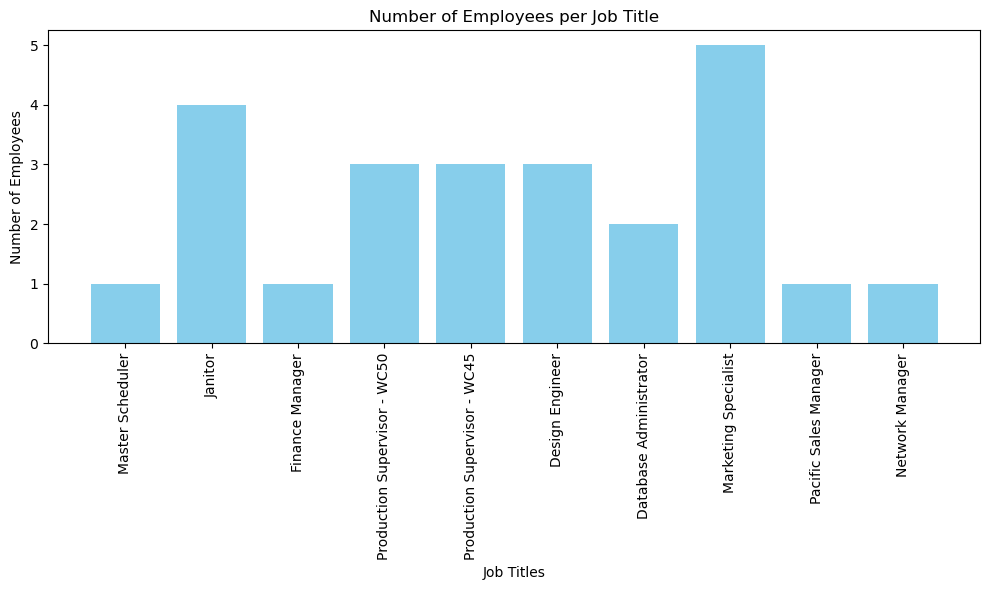

In [62]:
# 02 HumanResources



sql_query = """
SELECT TOP 10
    JobTitle,
    MIN(HireDate) AS EarliestHireDate,
    MAX(HireDate) AS LatestHireDate,
    AVG(YEAR(GETDATE()) - YEAR(BirthDate)) AS AverageAge,
    COUNT(*) AS NumberOfEmployees
FROM 
    HumanResources.Employee
GROUP BY 
    JobTitle
ORDER BY 
    NEWID();
"""


data = pd.read_sql(sql_query, con=connection)
 #  antal anställda per jobbtitel
plt.figure(figsize=(10, 6))
plt.bar(data['JobTitle'], data['NumberOfEmployees'], color='skyblue')
plt.xlabel('Job Titles')
plt.ylabel('Number of Employees')
plt.title('Number of Employees per Job Title')
plt.xticks(rotation=90)  
plt.tight_layout()

plt.show()



In [63]:
# 03 PERSON
sql_person= """

SELECT TOP 11
    FirstName,
    LastName,
	PhoneNumber,
	EmailAddress,
    AddressLine1,
    City,
    PostalCode
  FROM 
    Person.Person
INNER JOIN Person.Address ON Person.Person.BusinessEntityID = Person.Address.AddressID
INNER JOIN Person.StateProvince ON Person.Address.StateProvinceID = Person.StateProvince.StateProvinceID
INNER JOIN Person.PersonPhone ON Person.Person.BusinessEntityID = Person.PersonPhone.BusinessEntityID
INNER JOIN Person.EmailAddress ON Person.Person.BusinessEntityID = Person.EmailAddress.BusinessEntityID
ORDER BY NEWID();
"""

da = pd.read_sql(sql_person, con=connection)
display(da)

,FirstName,LastName,PhoneNumber,EmailAddress,AddressLine1,City,PostalCode
0,Ovidiu,Cracium,719-555-0181,ovidiu0@adventure-works.com,1318 Lasalle Street,Bothell,98011
1,Dawn,Yuan,976-555-0113,dawn30@adventure-works.com,6535 Warmcastle Ct.,Oak Bay,V8P
2,Krystal,Zeng,1 (11) 500 555-0127,krystal22@adventure-works.com,"29bis, rue des Peupliers",Metz,57000
3,Kristin,Pal,1 (11) 500 555-0117,kristin13@adventure-works.com,1440 Willow Pass Dr.,Colma,94014
4,Raymond,Sara,1 (11) 500 555-0165,raymond12@adventure-works.com,750 Cataline Avenue,Chula Vista,91910
5,Natasha,Hernandez,807-555-0167,natasha4@adventure-works.com,8434 Kenmore,Oakland,94611
6,Janice,Bennett,627-555-0176,janice4@adventure-works.com,"82, rue Henri Gagnon",Colomiers,31770
7,Jacob,Thomas,297-555-0139,jacob10@adventure-works.com,3831 Frigate Ct,Oxford,OX14 4SE
8,Jose,Gonzalez,655-555-0121,jose44@adventure-works.com,647 Newport Drive,South Melbourne,3205
9,Lindsay,Nara,1 (11) 500 555-0157,lindsay17@adventure-works.com,5165 Cambridge Drive,Renton,98055


In [64]:
# från 04´01
s_sql = """
SELECT TOP 10
       ProductID
      ,Name
      ,ProductNumber
      ,SafetyStockLevel
FROM AdventureWorks2022.Production.Product
ORDER BY NEWID()
"""


join_df = pd.read_sql(sql=s_sql, con=connection)

# Blanda raderna slumpmässigt
join_df = join_df.sample(frac=1).head(10)

print(join_df)

   ProductID                          Name ProductNumber  SafetyStockLevel
4        834  ML Road Frame-W - Yellow, 42    FR-R72Y-42               500
8        729       LL Road Frame - Red, 60    FR-R38R-60               500
7        849        Men's Sports Shorts, M     SH-M897-M                 4
2        726       LL Road Frame - Red, 48    FR-R38R-48               500
9        385                    Hex Nut 13       HN-3824              1000
1          3               BB Ball Bearing       BE-2349               800
5        444                    Lock Nut 9       LN-1428              1000
6        438                    Lock Nut 5       LN-1024              1000
0        362            Thin-Jam Hex Nut 2       HJ-1428              1000
3        858         Half-Finger Gloves, S     GL-H102-S                 4


In [65]:
#0402
produktion_sql = """
SELECT TOP 10 
    P.ProductID,
    P.Name AS ProductName,
    P.ProductNumber,
    P.Color,
    P.StandardCost,
    P.ListPrice
FROM Production.Product AS P
WHERE 
    P.ProductID IS NOT NULL
    AND P.Name IS NOT NULL
    AND P.ProductNumber IS NOT NULL
    AND P.Color IS NOT NULL
    AND P.ListPrice IS NOT NULL
    AND P.ListPrice > 0
    AND P.StandardCost IS NOT NULL
    AND P.StandardCost > 0
ORDER BY NEWID();
    
     """
data_1 = pd.read_sql(sql=produktion_sql, con=connection)
display(data_1)

,ProductID,ProductName,ProductNumber,Color,StandardCost,ListPrice
0,752,"Road-150 Red, 52",BK-R93R-52,Red,2171.2942,3578.27
1,763,"Road-650 Red, 48",BK-R50R-48,Red,486.7066,782.99
2,899,"LL Touring Frame - Yellow, 44",FR-T67Y-44,Yellow,199.8519,333.42
3,782,"Mountain-200 Black, 38",BK-M68B-38,Black,1251.9813,2294.99
4,725,"LL Road Frame - Red, 44",FR-R38R-44,Red,187.1571,337.22
5,744,"HL Mountain Frame - Black, 44",FR-M94B-44,Black,699.0928,1349.60
6,962,"Touring-3000 Yellow, 50",BK-T18Y-50,Yellow,461.4448,742.35
7,977,"Road-750 Black, 58",BK-R19B-58,Black,343.6496,539.99
8,861,"Full-Finger Gloves, S",GL-F110-S,Black,15.6709,37.99
9,999,"Road-750 Black, 52",BK-R19B-52,Black,343.6496,539.99


,BusinessEntityID,FirstName,LastName,NumberOfOrders,NumberOfStores,SalesYTD,SalesLastYear,TotalDue
0,277,Jillian,Carson,35948,76,3.189418e+06,1.997186e+06,8.620213e+08
1,275,Michael,Blythe,34650,77,3.763178e+06,1.750406e+06,8.066033e+08
2,279,Tsvi,Reiter,34320,80,2.315186e+06,1.849641e+06,6.468859e+08
3,282,José,Saraiva,20054,74,2.604541e+06,2.038235e+06,4.945817e+08
4,281,Shu,Ito,19118,79,2.458536e+06,2.073506e+06,5.735059e+08


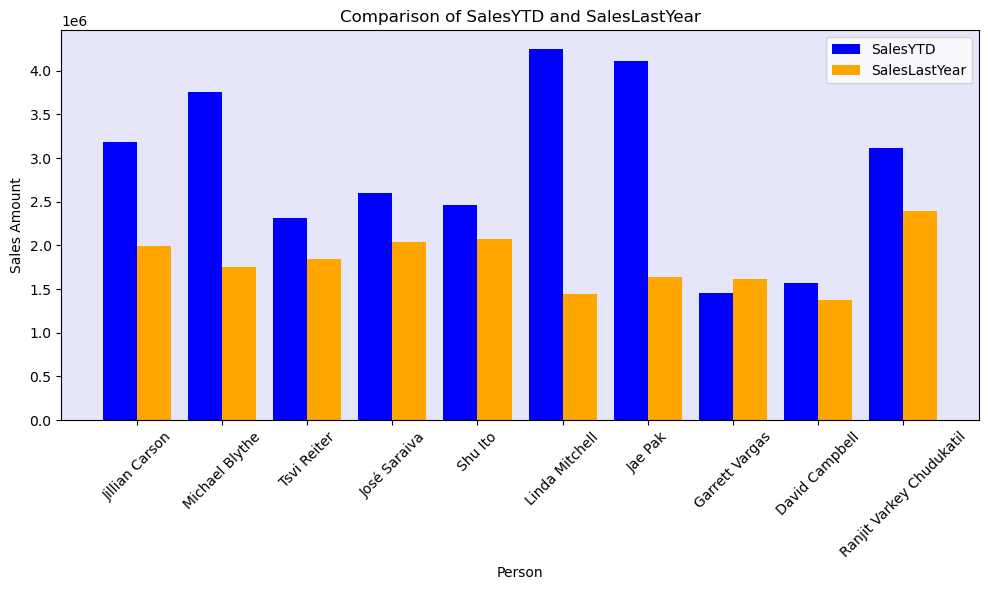

In [66]:
#0502
sql_query = """
SELECT TOP 10
    SP.BusinessEntityID,
	p.FirstName,
    p.LastName,
    COUNT(s.SalesOrderID) AS NumberOfOrders,       
    -- Antal butiker per säljare
    COUNT(DISTINCT st.BusinessEntityID) AS NumberOfStores,
    SP.SalesYTD,
    SP.SalesLastYear,
    SUM(s.TotalDue) as TotalDue
FROM 
    Sales.SalesOrderHeader s
INNER JOIN 
    Person.Person p ON s.SalesPersonID = p.BusinessEntityID
LEFT JOIN 
    Sales.Store st ON s.SalesPersonID = st.SalesPersonID
INNER JOIN 
    Sales.SalesPerson SP ON s.SalesPersonID = SP.BusinessEntityID
WHERE  s.SalesPersonID IS NOT NULL
GROUP BY 
    SP.BusinessEntityID,
    SP.SalesYTD,
    SP.SalesLastYear,
    p.FirstName,
    p.LastName
HAVING 
    COUNT(s.SalesOrderID) > 0
ORDER BY 
    NumberOfOrders DESC;

 """
df = pd.read_sql_query(sql_query, con=engine)
display(df.head())

plt.figure(figsize=(10, 6))

# Antag att indexet representerar person
x = df.index  
y_sales_ytd = df['SalesYTD']
y_sales_last_year = df['SalesLastYear']

#stapeldiagram för SalesYTD och SalesLastYear
plt.bar(x, y_sales_ytd, width=0.4, label='SalesYTD', color='blue')
plt.bar(x + 0.4, y_sales_last_year, width=0.4, label='SalesLastYear', color='orange')


plt.xlabel('Person')
plt.ylabel('Sales Amount')
plt.title('Comparison of SalesYTD and SalesLastYear')
plt.xticks(x + 0.2, df['FirstName'] + ' ' + df['LastName'], rotation=45)
plt.legend()
plt.gca().set_facecolor('lavender')

plt.tight_layout()
plt.show()




In [67]:
# FRÅGA 0501
W_sql = """
SELECT TOP 10
    so.SalesOrderID, so.OrderDate,
    c.CustomerID, c.PersonID, c.StoreID, c.TerritoryID,
    sp.BusinessEntityID, sp.TerritoryID, sp.SalesQuota, sp.Bonus,
    cc.CardNumber
FROM 
    Sales.SalesOrderHeader so
JOIN 
    Sales.Customer c ON so.CustomerID = c.CustomerID
JOIN 
    Sales.SalesPerson sp ON so.SalesPersonID = sp.BusinessEntityID
LEFT JOIN 
    Sales.CreditCard cc ON so.CreditCardID = cc.CreditCardID
	ORDER BY NEWID();
"""

join_df = pd.read_sql(sql=W_sql, con=connection)
join_df.head(10)

,SalesOrderID,OrderDate,CustomerID,PersonID,StoreID,TerritoryID,BusinessEntityID,TerritoryID,SalesQuota,Bonus,CardNumber
0,46665,2012-05-30,30057,1861,1862,5,279,5.0,300000.0,6700.0,33334077967968
1,55313,2013-08-30,29520,365,366,5,279,5.0,300000.0,6700.0,77775003200286
2,69545,2014-03-31,29616,597,598,4,274,NaN,NaN,0.0,11118478439271
3,63141,2013-12-31,29627,621,622,6,278,6.0,250000.0,500.0,77774951268299
4,48304,2012-10-30,29803,997,998,6,289,10.0,250000.0,5150.0,11119590512999
5,50681,2013-04-30,30049,1841,1842,7,290,7.0,250000.0,985.0,77772326496181
6,48322,2012-10-30,29775,937,938,1,284,1.0,300000.0,3900.0,55555015181337
7,48332,2012-10-30,30049,1841,1842,7,290,7.0,250000.0,985.0,77772326496181
8,43889,2011-07-01,29830,1055,1056,6,278,6.0,250000.0,500.0,55558681442592
9,47015,2012-06-30,29544,427,428,6,278,6.0,250000.0,500.0,55555295101678
